In [10]:
!pip install scikit-fuzzy


In [11]:
!pip install fuzzy-c-means


## **Step 1: Import Libraries**

In [12]:
import pandas as pd
import numpy as np
from skfuzzy import control as ctrl
from skfuzzy import membership as mf
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from matplotlib.dates import date2num
from fcmeans import FCM
from sklearn.metrics import mean_squared_error


## **Step 2: Load and Prepare Data**

In [13]:
# Load the dataset
file_path = 'Apple.csv'
apple_stock_data = pd.read_csv('/content/sample_data/Apple.csv')
apple_stock_data['Date'] = pd.to_datetime(apple_stock_data['Date'])
apple_stock_data.set_index('Date', inplace=True)
apple_stock_data = apple_stock_data.asfreq('B')
apple_stock_data['Open'] = apple_stock_data['Open'].fillna(method='ffill')


## **Step 3: Normalize Data and Cluster Analysis**

In [14]:
# Normalize the opening prices
open_prices = apple_stock_data['Open']
normalized_open = (open_prices - open_prices.min()) / (open_prices.max() - open_prices.min())

# Apply Fuzzy C-Means clustering
n_clusters = 5
fcm = FCM(n_clusters=n_clusters)
fcm.fit(normalized_open.values.reshape(-1, 1))
centers = np.sort(fcm.centers.flatten())


## **Step 4: Setup Fuzzy Variables and Rules**

In [15]:
# Define the universe of discourse for fuzzy variables
time = np.arange(len(normalized_open))
price = np.linspace(0, 1, len(normalized_open))

# Create fuzzy variables for time and price
time_fuzzy = ctrl.Antecedent(time, 'time')
price_fuzzy = ctrl.Consequent(price, 'price')

# Auto-membership function population for the time variable
time_fuzzy.automf(3)

# Custom membership functions for the price variable based on the centers from FCM
price_fuzzy['very_low'] = mf.trimf(price_fuzzy.universe, [0, 0, centers[0]])
price_fuzzy['low'] = mf.trimf(price_fuzzy.universe, [0, centers[0], centers[1]])
price_fuzzy['somewhat_low'] = mf.trimf(price_fuzzy.universe, [centers[0], centers[1], centers[2]])
price_fuzzy['medium'] = mf.trimf(price_fuzzy.universe, [centers[1], centers[2], centers[3]])
price_fuzzy['somewhat_high'] = mf.trimf(price_fuzzy.universe, [centers[2], centers[3], centers[4]])
price_fuzzy['high'] = mf.trimf(price_fuzzy.universe, [centers[3], centers[4], 1])
price_fuzzy['very_high'] = mf.trimf(price_fuzzy.universe, [centers[4], 1, 1])

# Define fuzzy rules
rules = [
    ctrl.Rule(time_fuzzy['poor'], price_fuzzy['very_low']),
    ctrl.Rule(time_fuzzy['average'], price_fuzzy['medium']),
    ctrl.Rule(time_fuzzy['good'], price_fuzzy['very_high']),
]

# Create the control system and simulation object
price_control_system = ctrl.ControlSystem(rules)
price_simulation = ctrl.ControlSystemSimulation(price_control_system)

## **Step 5: Perform Simulation and Forecast Evaluation**

In [16]:
# Perform the simulation
forecasts = []
for i in range(len(time)):
    price_simulation.input['time'] = i
    price_simulation.compute()
    forecasts.append(price_simulation.output['price'])

# Reverse normalization for the historical part
historical_forecasted_prices = np.array(forecasts) * (open_prices.max() - open_prices.min()) + open_prices.min()

# Calculate RMSE for the historical forecasts
historical_rmse = np.sqrt(mean_squared_error(open_prices, historical_forecasted_prices))

# Generate future dates for forecasting
forecast_length = 365  # Number of days to forecast into the future
last_date = open_prices.index[-1]
future_dates = pd.date_range(start=last_date, periods=forecast_length + 1, freq='B')[1:]

# Predict the trend into the future using linear regression on the 'Open' price
last_100_days = open_prices[-100:]
last_100_days_dates = date2num(last_100_days.index.to_pydatetime())
X = last_100_days_dates.reshape(-1, 1)
y = last_100_days.values
model = LinearRegression()
model.fit(X, y)
future_dates_num = date2num(future_dates.to_pydatetime())
future_trend = model.predict(future_dates_num.reshape(-1, 1))


## **Step 6: Visualization and Output**

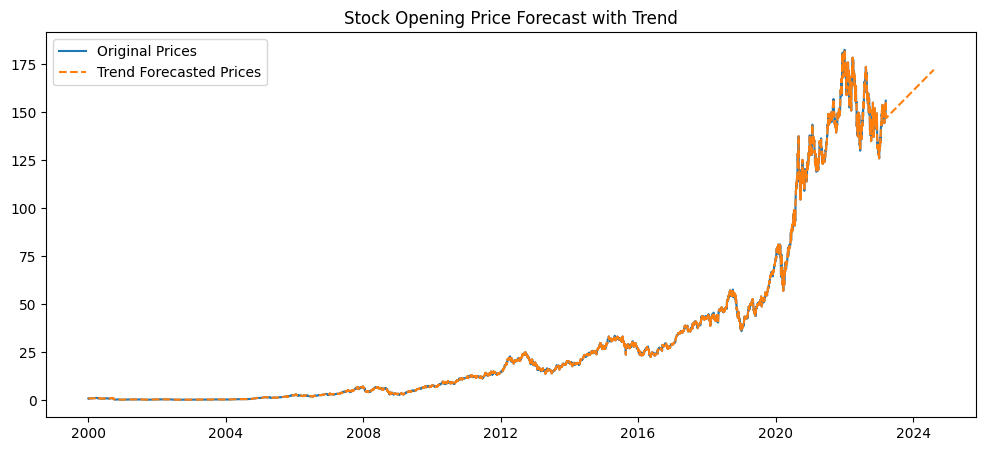

Historical RMSE: 55.3085065756076


In [18]:
# Combine historical opening prices with future trend for plotting
combined_prices = np.concatenate((open_prices.values, future_trend))

# Combine the historical and future dates
forecast_dates = open_prices.index.union(future_dates)

# Plot the original and forecasted prices with the trend
plt.figure(figsize=(12, 5))
plt.plot(open_prices.index, open_prices, label='Original Prices')
plt.plot(forecast_dates, combined_prices, label='Trend Forecasted Prices', linestyle='--')
plt.title('Stock Opening Price Forecast with Trend')
plt.legend()
plt.show()

print(f'Historical RMSE: {historical_rmse}')
